# This will train a 3D-CNN with the ROI dataset.


In [9]:
from torch import nn
import torch
import torch.optim as optim
from tqdm import *
import matplotlib.pyplot as plt
from kornia.losses import focal # pip3 install kornia will be required
import numpy as np
from sklearn import metrics
from pathlib import Path
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#### 1) Loading the dataset

In [10]:
# Load the already computed ROI dataset



data_base = Path("/home/jovyan/shared/NSD")
curr_subj = "subj01"
subj_behav_file = data_base / f"nsddata/ppdata/{curr_subj}/behav/responses.tsv"
subj_behav = pd.read_csv(subj_behav_file, delimiter="\t")

# add within session iteration indices
for sess_id in range(1, 37+1):
    subj_behav.loc[subj_behav["SESSION"]==sess_id, "INSESSIONIDX"] = list(range(1, 750+1))
    

subj_behav_sel = subj_behav.dropna(subset=["BUTTON"])
subj_behav_sel = subj_behav_sel[~subj_behav_sel["SESSION"].isin([38, 39, 40])]


# take the first saved data
betas = np.load("./nsd-data/MTL-1_full.npy")
print(betas.shape)
#betas = betas.reshape((betas.shape[3],betas.shape[0],betas.shape[1],betas.shape[2] ))

X = betas[subj_behav_sel.index, :] / 300
y = subj_behav_sel["ISOLDCURRENT"].to_numpy()

#print(X.shape)

(27750, 345)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### 2) Build the 3D-CNN 

In [12]:




print("\n================== 3D-CNN classifier ====================\n")

input_dims = [X.shape[1]]
train_dataset_size = X_train.shape[0]
test_dataset_size = X_test.shape[0]
train_dataset_ids = [i for i in range(train_dataset_size)]
minibatch_size = 32


# ======= model creation

#torch.nn.Conv3d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

model = nn.Sequential(
    nn.Conv1d(1,8, 121), #input_nb_channels=1, output_nb_channels=1, kernel size
    nn.SELU(),
    nn.Conv1d(8,16,99),
    nn.SELU(),
    nn.Conv1d(16,16,57),
    nn.SELU(),
    nn.Dropout(p=0.5),
    nn.Conv1d(16,32,33),
    nn.SELU(),
    nn.Conv1d(32,32,21),
    nn.SELU(),
    nn.Conv1d(32,32,9),
    nn.SELU(),
    nn.Dropout(p=0.5),
    nn.Flatten(),
    # resampled 25 version
    nn.Linear(352, 2), # Output size of the previous layer, output size = 1 (probability)
    # all 125 version
    # nn.Linear(238, 2), # Output size of the previous layer, output size = 1 (probability)
    #nn.Dropout(),
    nn.Softmax(dim=1)
    # nn.Linear(238, 1), # Output size of the previous layer, output size = 1 (probability)
    # nn.Sigmoid() # proba
)


#========== hyperparameters (optuna)

#lr, w_decay = 3e-4, 0.0 # TODO change
w_decay = 0.0
#lr = 0.0002211315921746536 # optuna results
lr = 2e-4#1e-3 ok but maybe too big
#gamma = 30#30#100#5#100.0#10.0 any gamma value seems to work /!\ the biggest gamma is, the more weight is given to less present data (ie true positive)
# 5 is too small (no true positive); but 100 is too high (not enough true negatives)
#gamma = 36.41489981311975 # optuna results
gamma = 10
alpha = 0.5#1.0#1.0 works#0.5 works #0.0 does not work
'''
alpha: Weighting factor :math:`\alpha \in [0, 1]`.
        gamma: Focusing parameter :math:`\gamma >= 0`.
'''

# ==== optimizer & loss function
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay= w_decay)
# Loss = nn.BCEWithLogitsLoss()





================== 3D-CNN classifier ====================



print(X_train.shape)
indices = [2,543, 900]
minibatch_X = X_train[indices, :,:,:]
print(minibatch_X.shape)
print(y_train.shape)
print(y_train[indices])
print(y_train[:5])

  0%|          | 0/70000 [00:00<?, ?it/s]

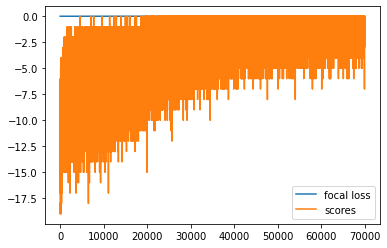

In [13]:

# ==== training loop
losses = []
scores = []
epochs = 70000
#epochs = 100000
#epochs = 10000#2000
# epochs = 1000
# epochs = 200
pbar = tqdm(range(epochs))
for epoch in pbar:
    pbar.set_description(str(epoch))

    # 1) fetch minibatch
    minibatch_ids = np.random.choice(train_dataset_ids, size=minibatch_size)
    
    #minibatch_list = []
    #minibatch_labels_list = []
    #for id in minibatch_ids:
        #minibatch_list.append(dataset['X'][id])
        #minibatch_labels_list.append(dataset['y'][id])
        
    
    minibatch_X = X_train[minibatch_ids, :]
    minibatch_y = y_train[minibatch_ids]
    

    minibatch_tensor_input = torch.tensor(minibatch_X ).float().reshape(minibatch_size, 1, input_dims[0]) # the additional 1 = number of input channels
    minibatch_tensor_labels = torch.tensor(minibatch_y).reshape(minibatch_size, 1)
    
    # print(minibatch_tensor_labels.size())
    # print(minibatch_tensor_labels)

    # 2) get outputs probabilities (target, non target)
    minibatch_tensor_output = model(minibatch_tensor_input)
    #print(minibatch_tensor_output)
    # print(minibatch_tensor_output.size())

    #3) compute loss function
    # print(minibatch_tensor_output.reshape(minibatch_size), minibatch_tensor_labels.reshape(minibatch_size))
    # print(minibatch_tensor_output, minibatch_tensor_labels)
    optimizer.zero_grad()


    loss = focal.focal_loss(minibatch_tensor_output, minibatch_tensor_labels.reshape(minibatch_size), alpha=alpha, gamma=gamma).mean() # works
    # print(loss)
    
    # ====== Adding L2 regularization =============
    #l2_lambda = 0.001
    #l2_norm = sum(p.pow(2.0).sum()
    #              for p in model.parameters())
 
    #loss = loss + l2_lambda * l2_norm
    
    # =============================================
    
    
    losses.append(loss.detach())
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1e-2) # avoid exploding gradients
    optimizer.step()


    # === compute scores TODO remove !!! OR SET IT ON A TEST SET !!!
    estimations = torch.argmax(minibatch_tensor_output, dim=1)
    #print(estimations)
    #print(minibatch_tensor_labels.reshape(minibatch_size))
    score = -sum(torch.pow(estimations - minibatch_tensor_labels.reshape(minibatch_size), 2)) # a perfect score is equal to 0, a bad score is very negative
    #print(score)
    scores.append(score)


plt.plot(losses, label='focal loss')
plt.plot(scores, label='scores')
plt.legend()
plt.show()




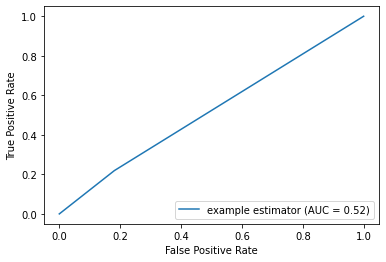

--> roc_auc:  0.5191119405713631


In [14]:

# =============== END OF TRAINING PERFORMANCES = see performances on testing set TODO adapt
# 1) fetch test data
test_tensor_input = torch.tensor(X_test).float().reshape(test_dataset_size, 1, input_dims[0])
test_tensor_labels = torch.tensor(y_test).reshape(test_dataset_size, 1)


# 2) get outputs probabilities (target, non target)
model.eval() # disable dropout for test time
with torch.no_grad():
    test_tensor_output = model(test_tensor_input)

# === compute scores TODO remove !!! OR SET IT ON A TEST SET !!!
y_pred = torch.argmax(test_tensor_output, dim=1)


# --- Plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(test_tensor_labels.numpy().flatten(),y_pred.numpy(), pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()
plt.show()
print("--> roc_auc: ", roc_auc)

In [15]:
conf_mat = confusion_matrix(y_test, y_pred)
# Thus in binary classification, the count of true negatives is C00, false negatives is C1O , true positives is C11 and false positives is C01 .
conf_mat

array([[5730, 1266],
       [1685,  473]])

In [16]:


cr = classification_report(y_test, y_pred, output_dict=True)
print(cr)
print('--> Accuraccy: ', cr['accuracy'])


{'0': {'precision': 0.772757923128793, 'recall': 0.8190394511149228, 'f1-score': 0.7952258691277497, 'support': 6996}, '1': {'precision': 0.2719953996549741, 'recall': 0.21918443002780352, 'f1-score': 0.24275083397485245, 'support': 2158}, 'accuracy': 0.6776272667686257, 'macro avg': {'precision': 0.5223766613918835, 'recall': 0.5191119405713631, 'f1-score': 0.5189883515513011, 'support': 9154}, 'weighted avg': {'precision': 0.6547061943046176, 'recall': 0.6776272667686257, 'f1-score': 0.6649832292042241, 'support': 9154}}
--> Accuraccy:  0.6776272667686257
